We test whether TDE can enhace prediction abilities of ESNs applied to the Lorenz System.

In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


## Simulating Lorenz Data

In [3]:
# Set up the Lorenz system and generate data
lorenz = Systems.lorenz63()

# Integrate the system
T = 200.0
Δt = 0.1
Ttr = 100.0  # Transient that will be discarded

tr = trajectory(lorenz, T, Δt = Δt, Ttr = Ttr)
x, y, z = columns(tr[1])

# Put the data in the matrix format (n_features, n_samples) required by ReservoirComputing.jl 
data = copy(hcat(x, y, z)')

3×2001 Matrix{Float64}:
  -7.9554  -15.3466  -13.1091  -3.50536  …   2.60804   4.85809   9.20262
 -14.5316  -21.0154   -3.5192   3.71577      4.24185   7.98143  14.6799
  12.6248   30.0779   41.0784  30.7804      17.4522   15.3366   18.8447

In [4]:
l_max = lyapunov(lorenz, 100, Ttr = 100)

0.8986638632954478

In [5]:
# make data stochastic
var = 4
data_rand = data + var * randn(size(data)) 

3×2001 Matrix{Float64}:
  -6.74861  -18.7335  -15.927    -2.20694   …  -1.42202   7.00872  12.9603
 -15.9938   -19.9227   -7.27465  -0.822301      2.47504   8.37076  17.6812
  17.4054    29.3164   43.1548   38.0574       19.5465   18.7686   21.0384

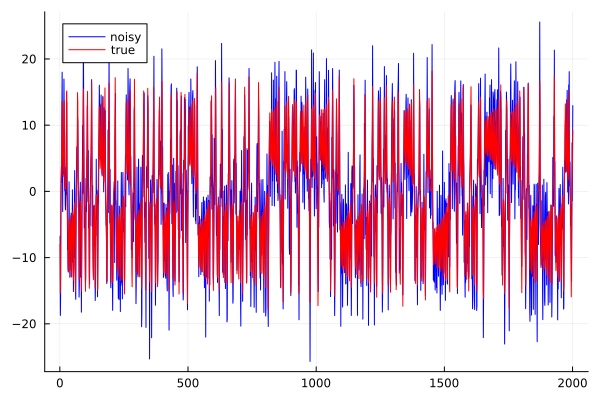

In [6]:
# visually check stochasticity
plot(data_rand[1, :], color="blue", label = "noisy")
plot!(data[1,:], color = "red", label ="true")

## Tools

In [7]:
"""
    train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)

Split the given data into training, validation, and test sets.
"""
function train_val_test_split(data, N_train, N_val)
    
    ind = N_train + N_val
    
    train_data = data[:, 1:N_train]
    val_data = data[:, N_train+1:ind]
    test_data = data[:, ind+1:end]
    
    return train_data, val_data, test_data
end

train_val_test_split

In [8]:
"""
    plot_prediction_tde_sep(esn_x, esn_y, esn_z, W_x, W_y, W_z, test_data_x,test_data_y,test_data_z, λ_max, title)

plot predictions versus the given test set, when TDE is performed seperately on different observables
"""
function plot_prediction_sep(esn_x, esn_y, esn_z, W_x, W_y, W_z, test_data_x,test_data_y,test_data_z, λ_max, title)
    
    prediction_x = esn_x(Generative(size(test_data_x, 2)), W_x)
    prediction_y = esn_y(Generative(size(test_data_y, 2)), W_y)
    prediction_z = esn_z(Generative(size(test_data_z, 2)), W_z)
    
    label = ["actual" "predicted"]
    times_x = Δt * collect(0:size(test_data_x, 2))[1:end-1] / λ_max
    times_y = Δt * collect(0:size(test_data_y, 2))[1:end-1] / λ_max
    times_z = Δt * collect(0:size(test_data_z, 2))[1:end-1] / λ_max

    print(test_data_z[1,:])

    p1 = plot(times_x, [test_data_x[1, :], prediction_x[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times_y, [test_data_y[1, :], prediction_y[1, :]], label = label, ylabel = "y(t)")
    p3 = plot(times_z, [test_data_z[1, :], prediction_z[1, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600), title=title)
end

plot_prediction_sep

In [9]:
"""
    plot_comparison(esn_1d, esn_tde, W_1d, W_tde, test_data, λ_max, title)

"""
function plot_comparison(esn_1d, esn_tde, W_1d, W_tde, test_data, λ_max, title)

    prediction_size = size(test_data, 2)
    
    prediction_1d = esn_1d(Generative(prediction_size), W_1d)
    prediction_tde = esn_1d(Generative(prediction_size), W_tde)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] / λ_max

    p2 = plot(times, [test_data[1, :], prediction_1d[1, :]], label = label, ylabel = "")
    p3 = plot(times, [test_data[1, :], prediction_tde[1, :]], label = label, ylabel = "", xlabel = "t * λ_max")
    plot(p2, p3, layout = (2, 1), size = (800, 600), title=title)
end

plot_comparison

In [10]:
"""
    plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

Given an Echo State Network, plot its predictions versus the given test set.
"""
function plot_prediction(esn, Wₒᵤₜ, test_data, λ_max, title)
    steps_to_predict = size(test_data, 2)
    prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] / λ_max

    p1 = plot(times, [test_data[1, :], prediction[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times, [test_data[2, :], prediction[2, :]], label = label, ylabel = "y(t)")
    p3 = plot(times, [test_data[3, :], prediction[3, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600), title=title)
end

plot_prediction

## TDE on each observable seperately

we perform a TDE of a 1D observation of the Lorenz System

In [11]:
# use random data 
data = data_rand

3×2001 Matrix{Float64}:
  -6.74861  -18.7335  -15.927    -2.20694   …  -1.42202   7.00872  12.9603
 -15.9938   -19.9227   -7.27465  -0.822301      2.47504   8.37076  17.6812
  17.4054    29.3164   43.1548   38.0574       19.5465   18.7686   21.0384

In [12]:
# perform TDE on x_data 
x_data_emb, τ, E = optimal_separated_de(data[1,:])
y_data_emb, τ, E = optimal_separated_de(data[2,:])
z_data_emb, τ, E = optimal_separated_de(data[3,:])

n = minimum([length(x_data_emb), length(y_data_emb),length(z_data_emb)])
x_data_emb = x_data_emb[1:n,:]
y_data_emb = y_data_emb[1:n,:]
z_data_emb = z_data_emb[1:n,:];

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Stochastic signal, valid embedding NOT achieved ⨉.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Stochastic signal, valid embedding NOT achieved ⨉.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


In [13]:
N_train = floor(Int, n * 0.8)
N_val = floor(Int, (n-N_train) /2)
N_test = n - N_train - N_val

198

In [14]:
train_x_data_emb, val_x_data_emb, test_x_data_emb = train_val_test_split(Matrix(x_data_emb)', N_train, N_val)
train_y_data_emb, val_y_data_emb, test_y_data_emb = train_val_test_split(Matrix(y_data_emb)', N_train, N_val)
train_z_data_emb, val_z_data_emb, test_z_data_emb = train_val_test_split(Matrix(z_data_emb)', N_train, N_val)


([17.40544066996448 29.31640610142454 … 39.011768766238745 27.68566665924839; 43.154803917375865 38.057363074756864 … 21.415155738708762 9.02219162040949; … ; 19.114005253796886 24.900162713318732 … 16.433223760291735 15.25579013888976; 11.741008052202197 12.147033013620849 … 31.061087673472553 36.04454139217854], [21.415155738708762 9.02219162040949 … 25.74186287286606 33.692798304839705; 16.321791947056994 23.016444670645377 … 33.96414079869453 25.29289339130402; … ; 31.061087673472553 36.04454139217854 … 21.998138214044076 21.121129966221; 29.523523356667614 22.539699035680737 … 19.913391556028508 19.764167512481233], [33.96414079869453 25.29289339130402 … 19.076187660866744 21.433682549336403; 14.089172900724364 21.1060320101483 … 30.436821834147928 31.669921869109707; … ; 19.913391556028508 19.764167512481233 … 29.572465731125813 26.778255821093524; 35.85295944148649 34.773961446733715 … 17.87985205203701 20.563701850469087])

In [19]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [450, 470, 490, 1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

esn_x_emb, W_out_x_emb, val_loss_x_emb = enso_project.cross_validate_esn(train_x_data_emb, val_x_data_emb, param_grid)

enso_project.ESNHyperparams(450, 0.8, 0.03, 0.1, 0.0)
Validation loss = 175917.1277432712
enso_project.ESNHyperparams(470, 1.0, 0.03, 0.1, 0.0)
Validation loss = 152871.55708794907
enso_project.ESNHyperparams(470, 1.2, 0.03, 0.1, 0.0)
Validation loss = 130486.32972538704
enso_project.ESNHyperparams(470, 0.8, 0.05, 0.1, 0.0)
Validation loss = 117353.84696283248
enso_project.ESNHyperparams(470, 0.8, 0.05, 0.1, 1.0e-6)
Validation loss = 117304.48110953334
enso_project.ESNHyperparams(470, 0.8, 0.05, 0.1, 1.0e-5)
Validation loss = 117220.80275103769


(ESN(6 => 470), OutputLayer successfully trained with output size: 6, 117220.80275103769)

In [20]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [600, 650, 700, 750, 800]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

esn_y_emb, W_out_y_emb, val_loss_y_emb = enso_project.cross_validate_esn(train_y_data_emb, val_y_data_emb, param_grid)

enso_project.ESNHyperparams(600, 0.8, 0.03, 0.1, 0.0)
Validation loss = 195390.9451719767
enso_project.ESNHyperparams(700, 0.8, 0.03, 0.1, 0.0)
Validation loss = 190433.863687652
enso_project.ESNHyperparams(600, 1.2, 0.03, 0.1, 0.0)
Validation loss = 190197.99125507424
enso_project.ESNHyperparams(650, 1.2, 0.03, 0.1, 0.0)
Validation loss = 157984.82563913852
enso_project.ESNHyperparams(650, 1.2, 0.03, 0.1, 1.0e-5)
Validation loss = 149490.3637557037


(ESN(6 => 650), OutputLayer successfully trained with output size: 6, 149490.3637557037)

In [21]:
spectral_radii = [0.9]
sparsities = [0.05]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [560, 600]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

esn_z_emb, W_out_z_emb, val_loss_z_emb = enso_project.cross_validate_esn(train_z_data_emb, val_z_data_emb, param_grid)

enso_project.ESNHyperparams(560, 0.9, 0.05, 0.1, 0.0)
Validation loss = 5.247626368983318e15
enso_project.ESNHyperparams(600, 0.9, 0.05, 0.1, 0.0)
Validation loss = 267534.7141809114
enso_project.ESNHyperparams(600, 0.9, 0.05, 0.1, 1.0e-6)
Validation loss = 178371.3965834682
enso_project.ESNHyperparams(560, 0.9, 0.05, 1.0, 1.0e-6)
Validation loss = 175568.038551923


(ESN(7 => 560), OutputLayer successfully trained with output size: 7, 175568.038551923)

## ESN training without TDE

In [22]:
data = data[:,1:n]

x_data_1d = Matrix(data[1,:]')
y_data_1d = Matrix(data[2,:]')
z_data_1d = Matrix(data[3,:]')


train_data_x_1D, val_data_x_1D, test_data_x_1D = train_val_test_split(x_data_1d, N_train, N_val)
train_data_y_1D, val_data_y_1D, test_data_y_1D = train_val_test_split(y_data_1d, N_train, N_val)
train_data_z_1D, val_data_z_1D, test_data_z_1D = train_val_test_split(z_data_1d, N_train, N_val)

([17.40544066996448 29.31640610142454 … 39.011768766238745 27.68566665924839], [21.415155738708762 9.02219162040949 … 25.74186287286606 33.692798304839705], [33.96414079869453 25.29289339130402 … 19.076187660866744 21.433682549336403])

In [23]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [512, 1024]

param_grid_x = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [24]:
# network training
esn_x_1D, W_out_x_1D, val_loss_x_1D = enso_project.cross_validate_esn(train_data_x_1D, val_data_x_1D, param_grid_x)

enso_project.ESNHyperparams(512, 0.8, 0.03, 0.1, 0.0)
Validation loss = 32632.34043299014
enso_project.ESNHyperparams(512, 1.0, 0.03, 0.1, 0.0)
Validation loss = 26458.90940992421
enso_project.ESNHyperparams(512, 1.2, 0.05, 0.1, 0.0)
Validation loss = 19711.738863275667
enso_project.ESNHyperparams(512, 1.2, 0.05, 0.1, 1.0e-6)
Validation loss = 18992.557838362776
enso_project.ESNHyperparams(512, 1.2, 0.05, 0.1, 1.0e-5)
Validation loss = 18173.298684089696


(ESN(1 => 512), OutputLayer successfully trained with output size: 1, 18173.298684089696)

In [25]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [512, 1024]

param_grid_y = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [26]:
esn_y_1D, W_out_y_1D, val_loss_y_1D = enso_project.cross_validate_esn(train_data_y_1D, val_data_y_1D, param_grid_y)

enso_project.ESNHyperparams(512, 0.8, 0.03, 0.1, 0.0)
Validation loss = 38241.83862158501
enso_project.ESNHyperparams(512, 0.8, 0.05, 0.1, 0.0)
Validation loss = 32074.828743565773
enso_project.ESNHyperparams(512, 1.0, 0.05, 0.1, 0.0)
Validation loss = 27889.23152644578
enso_project.ESNHyperparams(512, 1.0, 0.05, 0.1, 1.0e-5)
Validation loss = 25323.031728455244


(ESN(1 => 512), OutputLayer successfully trained with output size: 1, 25323.031728455244)

In [27]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [512, 1024]

param_grid_z = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [28]:
esn_z_1D, W_out_z_1D, val_loss_z_1D = enso_project.cross_validate_esn(train_data_z_1D, val_data_z_1D, param_grid_z)

enso_project.ESNHyperparams(512, 0.8, 0.03, 0.1, 0.0)
Validation loss = 26559.37185330059
enso_project.ESNHyperparams(512, 1.0, 0.03, 0.1, 0.0)
Validation loss = 17015.19356411311
enso_project.ESNHyperparams(512, 1.0, 0.03, 0.1, 1.0e-6)
Validation loss = 16997.565557859743
enso_project.ESNHyperparams(512, 1.0, 0.03, 0.5, 1.0e-6)
Validation loss = 14886.552605680434


(ESN(1 => 512), OutputLayer successfully trained with output size: 1, 14886.552605680434)

## Comparison

[33.96414079869453, 25.29289339130402, 14.089172900724364, 21.1060320101483, 15.144772744899594, 29.53419177372058, 31.236164246195553, 27.284198861321876, 21.998138214044076, 21.121129966221, 19.913391556028508, 19.764167512481233, 35.85295944148649, 34.773961446733715, 30.284592449519405, 20.856315807212074, 22.970418103811625, 16.84900698321135, 5.012497223156616, 20.910986071005308, 35.236289813977336, 36.4518137207602, 37.888133403108725, 24.389134705360885, 15.878443198079248, 14.757561408036949, 16.939247428427812, 13.450237222539783, 36.16019213333684, 30.796432281147123, 34.981622420999514, 21.279512712568096, 12.97567920933443, 10.111911811202702, 10.071020480218108, 22.56900378574338, 34.24487097730264, 38.8596637866739, 34.130770958676386, 26.478008851980384, 14.873653596124305, 10.030729013558481, 15.00141643784309, 31.420310948600044, 37.31807764640117, 23.685609911935437, 24.80268277244202, 16.861187485327807, 15.773155101961752, 1.5886266456594385, 11.692270387515675, -

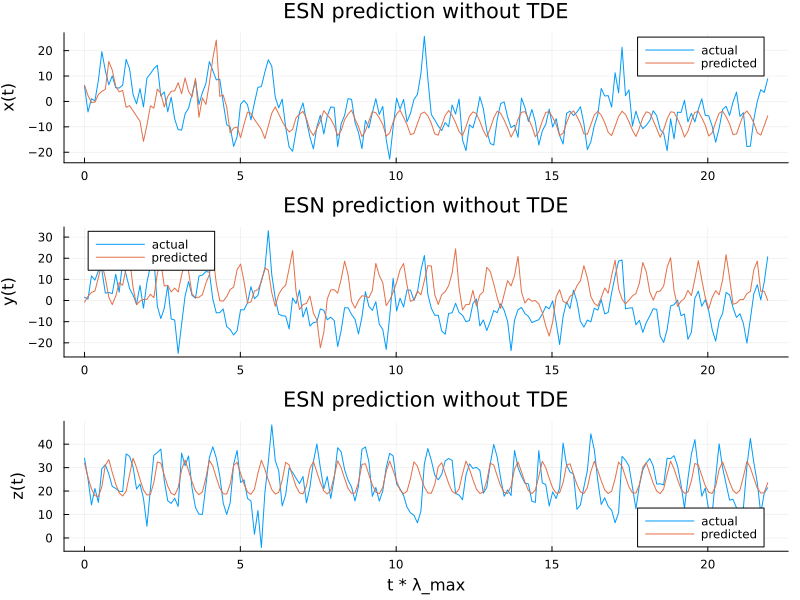

In [29]:
plot_prediction_sep(esn_x_1D,esn_y_1D,esn_z_1D, W_out_x_1D,  W_out_y_1D, W_out_z_1D,test_data_x_1D,test_data_y_1D,test_data_z_1D, l_max, "ESN prediction without TDE")

[33.96414079869453, 25.29289339130402, 14.089172900724364, 21.1060320101483, 15.144772744899594, 29.53419177372058, 31.236164246195553, 27.284198861321876, 21.998138214044076, 21.121129966221, 19.913391556028508, 19.764167512481233, 35.85295944148649, 34.773961446733715, 30.284592449519405, 20.856315807212074, 22.970418103811625, 16.84900698321135, 5.012497223156616, 20.910986071005308, 35.236289813977336, 36.4518137207602, 37.888133403108725, 24.389134705360885, 15.878443198079248, 14.757561408036949, 16.939247428427812, 13.450237222539783, 36.16019213333684, 30.796432281147123, 34.981622420999514, 21.279512712568096, 12.97567920933443, 10.111911811202702, 10.071020480218108, 22.56900378574338, 34.24487097730264, 38.8596637866739, 34.130770958676386, 26.478008851980384, 14.873653596124305, 10.030729013558481, 15.00141643784309, 31.420310948600044, 37.31807764640117, 23.685609911935437, 24.80268277244202, 16.861187485327807, 15.773155101961752, 1.5886266456594385, 11.692270387515675, -

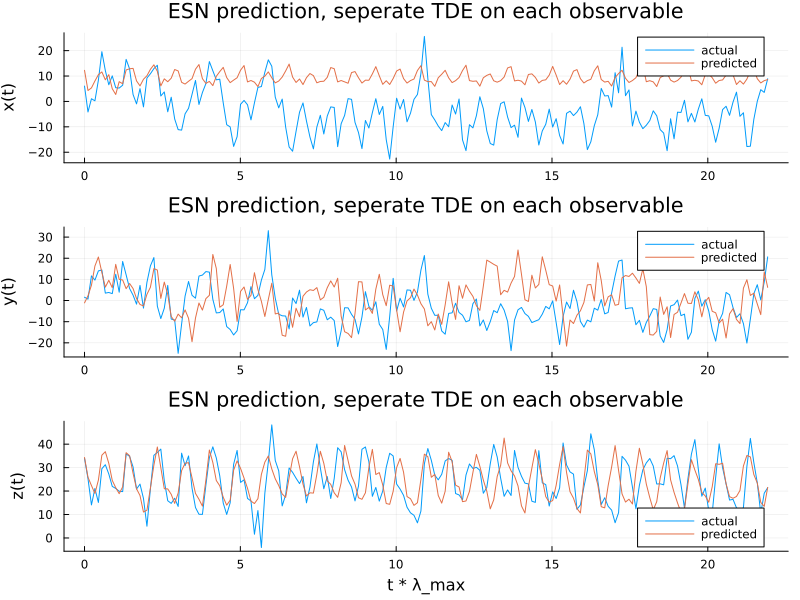

In [30]:
plot_prediction_sep(esn_x_emb, esn_y_emb,esn_z_emb, W_out_x_emb,W_out_y_emb, W_out_z_emb, test_x_data_emb,test_y_data_emb,test_z_data_emb, l_max, "ESN prediction, seperate TDE on each observable")